In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

In [2]:

IMG_SIZE = (128, 128)
base_path = '/content/drive/MyDrive/dataset/'


train_img_path = os.path.join(base_path, 'train/images')
train_mask_path = os.path.join(base_path, 'train/masks')

val_img_path = os.path.join(base_path, 'val/images')
val_mask_path = os.path.join(base_path, 'val/masks')

test_img_path = os.path.join(base_path, 'test/images')
test_mask_path = os.path.join(base_path, 'test/masks')

In [3]:
def load_dataset(img_dir, mask_dir):
    images = []
    masks = []

    img_filenames = sorted(os.listdir(img_dir))

    for filename in img_filenames:
        if filename.endswith('.jpg'):
            base_name = os.path.splitext(filename)[0]
            mask_name = base_name + '.png'

            img_path = os.path.join(img_dir, filename)
            mask_path = os.path.join(mask_dir, mask_name)

            if os.path.exists(mask_path):
                img = load_img(img_path, target_size=IMG_SIZE, color_mode='grayscale')
                img_array = img_to_array(img) / 255.0
                images.append(img_array)

                mask = load_img(mask_path, target_size=IMG_SIZE, color_mode='grayscale')
                mask_array = img_to_array(mask) / 255.0
                masks.append(mask_array)

    return np.array(images), np.array(masks)

In [4]:

train_images, train_masks = load_dataset(train_img_path, train_mask_path)
val_images, val_masks = load_dataset(val_img_path, val_mask_path)
test_images, test_masks = load_dataset(test_img_path, test_mask_path)


print(f"Training Images Shape: {train_images.shape}")
print(f"Training Masks Shape: {train_masks.shape}")

print(f"Validation Images Shape: {val_images.shape}")
print(f"Validation Masks Shape: {val_masks.shape}")

print(f"Test Images Shape: {test_images.shape}")
print(f"Test Masks Shape: {test_masks.shape}")

Training Images Shape: (811, 128, 128, 1)
Training Masks Shape: (811, 128, 128, 1)
Validation Images Shape: (203, 128, 128, 1)
Validation Masks Shape: (203, 128, 128, 1)
Test Images Shape: (254, 128, 128, 1)
Test Masks Shape: (254, 128, 128, 1)


In [5]:
def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder Path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)

    # Decoder Path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [ ]:
# Create the model
model = unet_model(input_size=(IMG_SIZE[0], IMG_SIZE[1], 1))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display the model's structure
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    131,200 │ conv2d_4[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │      8,224 │ conv2d_6[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                 

 Total params: 958,577 (3.66 MB)

 Trainable params: 958,577 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
EPOCHS = 25
BATCH_SIZE = 16

history = model.fit(
    train_images,
    train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_masks)
)

Epoch 1/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 23s 204ms/step - accuracy: 0.0048 - loss: 0.6690 - val_accuracy: 0.0187 - val_loss: 0.6488
Epoch 2/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.0230 - loss: 0.6397 - val_accuracy: 0.0300 - val_loss: 0.6329
Epoch 3/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0269 - loss: 0.6258 - val_accuracy: 0.0218 - val_loss: 0.6250
Epoch 4/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0272 - loss: 0.6173 - val_accuracy: 0.0282 - val_loss: 0.6193
Epoch 5/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0309 - loss: 0.6121 - val_accuracy: 0.0282 - val_loss: 0.6148
Epoch 6/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.0322 - loss: 0.6074 - val_accuracy: 0.0288 - val_loss: 0.6152
Epoch 7/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.0275 - loss: 0.6080 - val_accuracy: 0.0285 - val_loss: 0.6101
Epoch 8/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0332 - loss: 0.6049 - val_accuracy: 0.0317 -

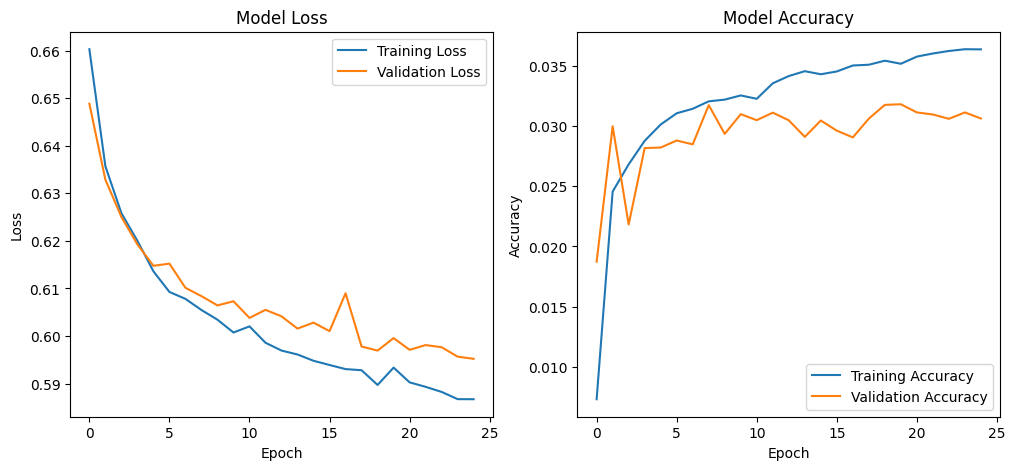

In [ ]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


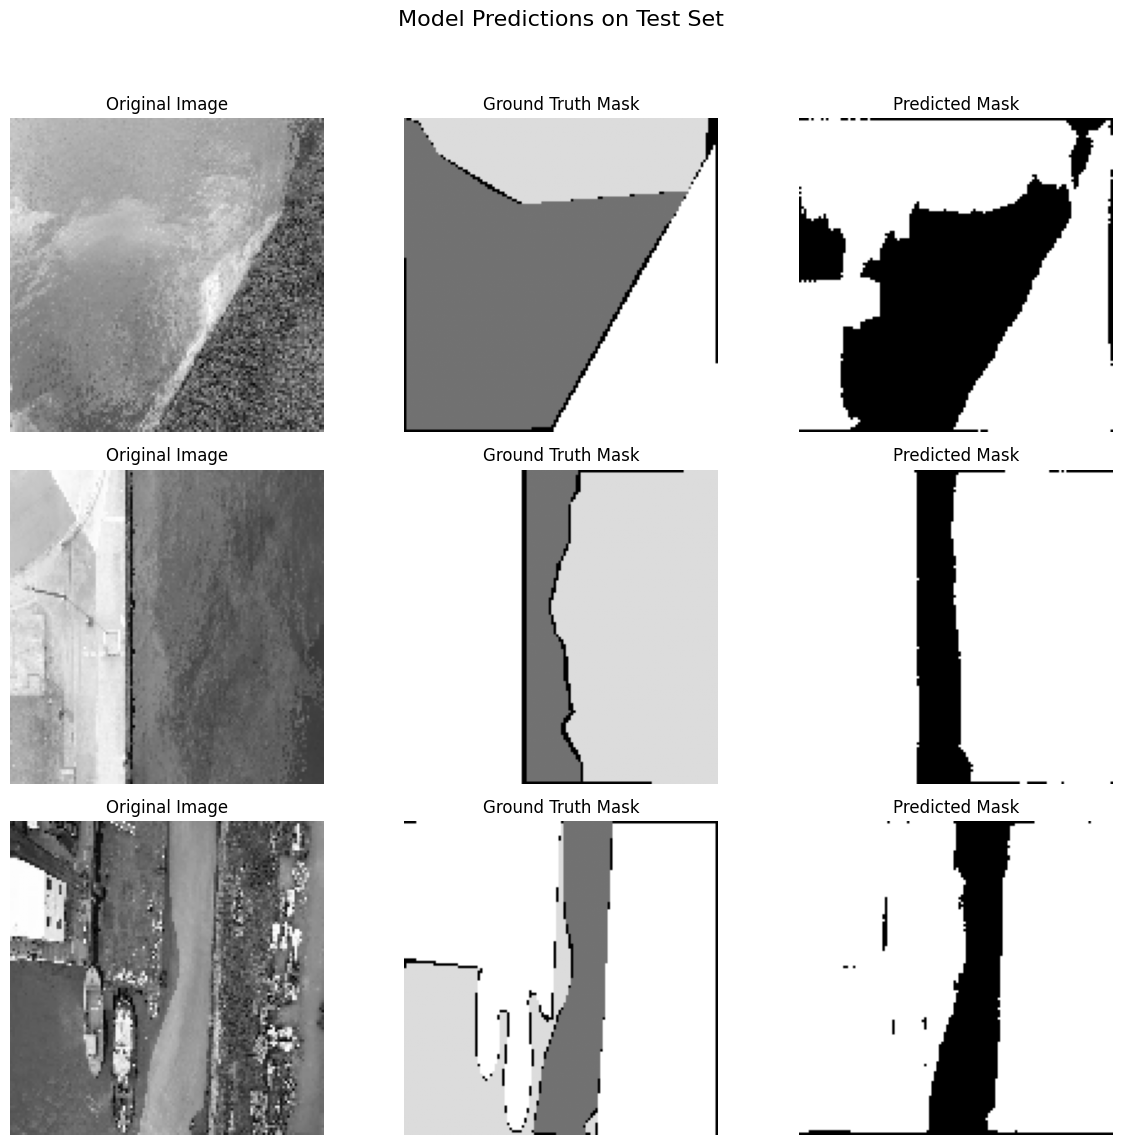

In [ ]:
import random

# Select a few random images from the test set
num_samples = 3
plt.figure(figsize=(12, 4 * num_samples))
plt.suptitle('Model Predictions on Test Set', fontsize=16)

for i in range(num_samples):
    # Get a random index
    idx = random.randint(0, len(test_images) - 1)

    # Get the image, mask, and make a prediction
    test_img = test_images[idx]
    true_mask = test_masks[idx]
    pred_mask_prob = model.predict(np.expand_dims(test_img, axis=0))[0]

    # Apply a threshold to the prediction to get a binary mask
    pred_mask = (pred_mask_prob > 0.5).astype(np.uint8)

    # Plot Original Image
    plt.subplot(num_samples, 3, i * 3 + 1)
    plt.imshow(test_img.squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Plot Ground Truth
    plt.subplot(num_samples, 3, i * 3 + 2)
    plt.imshow(true_mask.squeeze(), cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    # Plot Predicted Mask
    plt.subplot(num_samples, 3, i * 3 + 3)
    plt.imshow(pred_mask.squeeze(), cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [6]:
import numpy as np

# Find all unique pixel values in the masks
unique_values = set()
for mask in train_masks:
    unique_values.update(np.unique(mask).tolist())

print("Unique pixel values found in masks (normalized):")
print(sorted(list(unique_values)))

# To see the original values (0-255 range)
print("\nUnique pixel values found in masks (original 0-255 scale):")
original_values = [int(v * 255) for v in sorted(list(unique_values))]
print(original_values)

Unique pixel values found in masks (normalized):
[0.0, 0.3529411852359772, 0.6823529601097107, 0.7921568751335144]

Unique pixel values found in masks (original 0-255 scale):
[0, 90, 174, 202]


In [7]:
from tensorflow.keras.utils import to_categorical

# The unique pixel values are our class labels
class_labels = [0, 90, 174, 202]
num_classes = len(class_labels)

# Create a mapping from label value to an integer index (0, 1, 2, 3)
label_map = {label: i for i, label in enumerate(class_labels)}

def preprocess_masks(masks_array):
    # Create an integer-labeled mask
    int_mask = np.zeros(masks_array.shape[:3], dtype=np.uint8)
    for val, i in label_map.items():
        int_mask[masks_array[:, :, :, 0] == val / 255.0] = i

    # One-hot encode the integer mask
    one_hot_mask = to_categorical(int_mask, num_classes=num_classes)
    return one_hot_mask

# Preprocess all your masks
train_cat = preprocess_masks(train_masks)
val_cat = preprocess_masks(val_masks)
test_cat = preprocess_masks(test_masks)

print(f"Original train masks shape: {train_masks.shape}")
print(f"New one-hot encoded train masks shape: {train_cat.shape}")

Original train masks shape: (811, 128, 128, 1)
New one-hot encoded train masks shape: (811, 128, 128, 4)


In [8]:
def unet_multiclass(input_size=(128, 128, 1), num_classes=4):
    inputs = Input(input_size)

    # Encoder Path (same as before)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)

    # Decoder Path (same as before)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)

    # --- THIS IS THE ONLY CHANGE ---
    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

In [9]:
# Create the new model
multi_model = unet_multiclass(input_size=(IMG_SIZE[0], IMG_SIZE[1], 1), num_classes=num_classes)

# Compile the model with the correct loss and a better metric
multi_model.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=[tf.keras.metrics.MeanIoU(num_classes=num_classes)])

# Display the model's structure
multi_model.summary()

# Train the new model
EPOCHS = 25
BATCH_SIZE = 16

history2 = multi_model.fit(
    train_images,
    train_cat,  # Use the new one-hot encoded masks
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_images, val_cat) # Use the new one-hot encoded masks
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 16, 16,    │    131,200 │ conv2d_4[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 16, 16,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 32, 32,    │     32,832 │ conv2d_5[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,792 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 64, 64,    │      8,224 │ conv2d_6[0][0]    │
│ (Conv2DTranspose)   │ 32)               │            │                 

 Total params: 958,628 (3.66 MB)

 Trainable params: 958,628 (3.66 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 243ms/step - loss: 1.1707 - mean_io_u: 0.3750 - val_loss: 0.8161 - val_mean_io_u: 0.3750
Epoch 2/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 28ms/step - loss: 0.7784 - mean_io_u: 0.3750 - val_loss: 0.6326 - val_mean_io_u: 0.3750
Epoch 3/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.6083 - mean_io_u: 0.3750 - val_loss: 0.5347 - val_mean_io_u: 0.3750
Epoch 4/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.5653 - mean_io_u: 0.3753 - val_loss: 0.4898 - val_mean_io_u: 0.3750
Epoch 5/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.4804 - mean_io_u: 0.3756 - val_loss: 0.4365 - val_mean_io_u: 0.3750
Epoch 6/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.4184 - mean_io_u: 0.3754 - val_loss: 0.4288 - val_mean_io_u: 0.3758
Epoch 7/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.4128 - mean_io_u: 0.3758 - val_loss: 0.3884 - val_mean_io_u: 0.3750
Epoch 8/25
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.3740 - mean_io_u: 0.3754 - val_lo

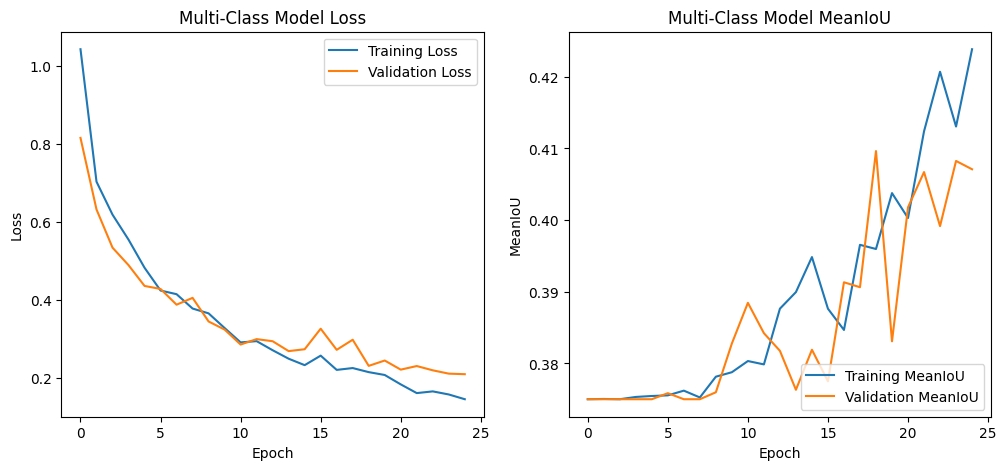

In [10]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Training Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Multi-Class Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot training & validation MeanIoU values
plt.subplot(1, 2, 2)
plt.plot(history2.history['mean_io_u'], label='Training MeanIoU')
plt.plot(history2.history['val_mean_io_u'], label='Validation MeanIoU')
plt.title('Multi-Class Model MeanIoU')
plt.ylabel('MeanIoU')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


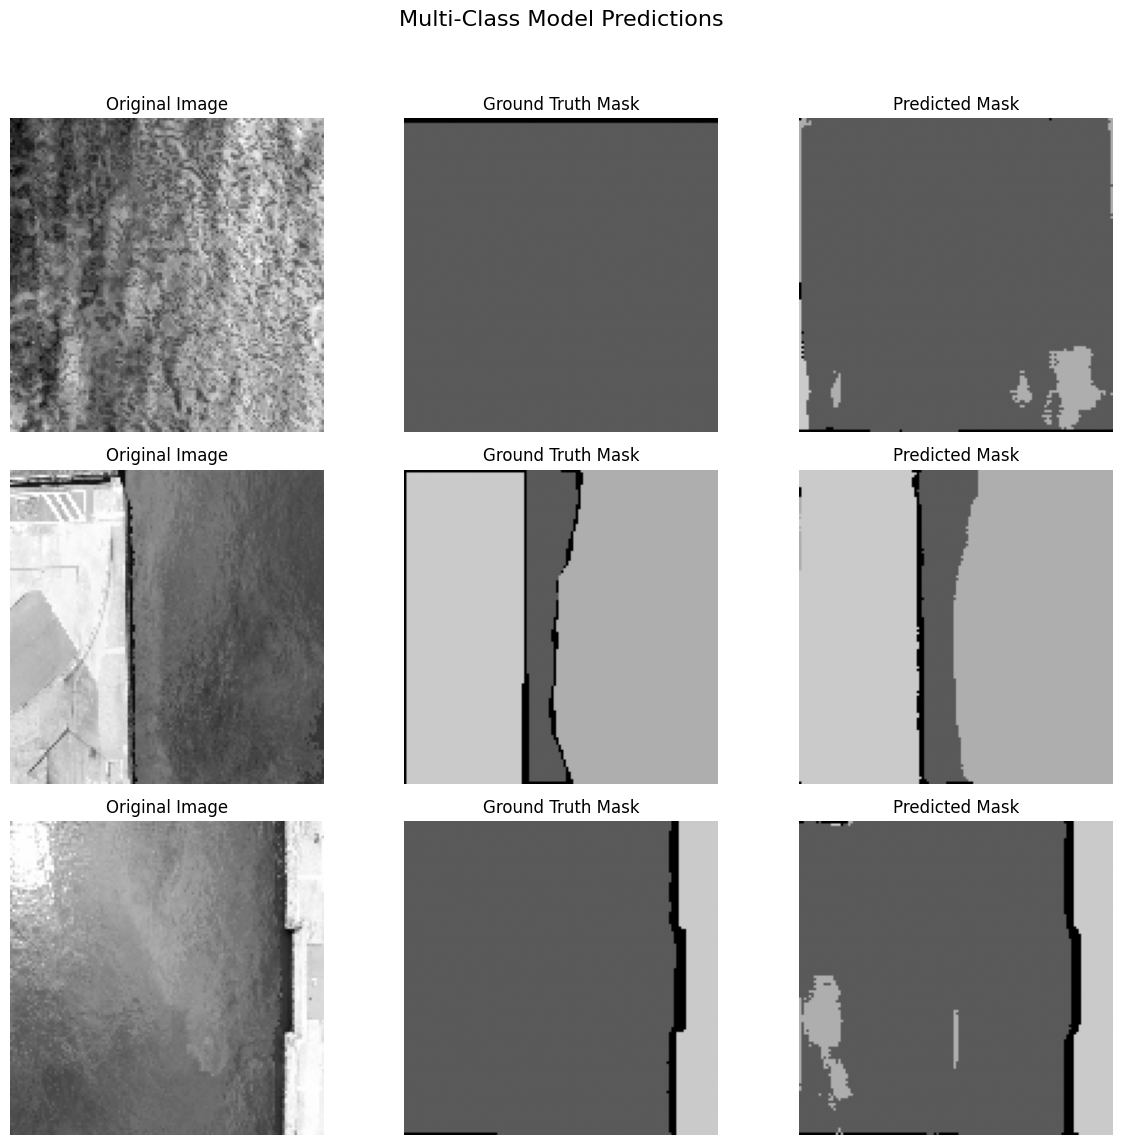

In [11]:
import random

# The original pixel values for each class
class_labels = [0, 90, 174, 202]

def display_multiclass_predictions(num_samples=3):
    plt.figure(figsize=(12, 4 * num_samples))
    plt.suptitle('Multi-Class Model Predictions', fontsize=16)

    for i in range(num_samples):
        idx = random.randint(0, len(test_images) - 1)

        test_img = test_images[idx]
        true_mask_one_hot = test_cat[idx]

        # Get model prediction (4 channels of probabilities)
        pred_mask_prob = multi_model.predict(np.expand_dims(test_img, axis=0))[0]
        # Get the class with the highest probability for each pixel
        pred_mask_indices = np.argmax(pred_mask_prob, axis=-1)

        # Convert the integer class indices back to the original pixel values for visualization
        pred_mask_colored = np.zeros_like(pred_mask_indices, dtype=np.uint8)
        for class_index, pixel_value in enumerate(class_labels):
            pred_mask_colored[pred_mask_indices == class_index] = pixel_value

        # Convert the one-hot encoded ground truth back to a single image for visualization
        true_mask_indices = np.argmax(true_mask_one_hot, axis=-1)
        true_mask_colored = np.zeros_like(true_mask_indices, dtype=np.uint8)
        for class_index, pixel_value in enumerate(class_labels):
            true_mask_colored[true_mask_indices == class_index] = pixel_value

        # Plot Original Image
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(test_img.squeeze(), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Plot Ground Truth
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(true_mask_colored, cmap='gray', vmin=0, vmax=255)
        plt.title('Ground Truth Mask')
        plt.axis('off')

        # Plot Predicted Mask
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(pred_mask_colored, cmap='gray', vmin=0, vmax=255)
        plt.title('Predicted Mask')
        plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run the visualization
display_multiclass_predictions()

In [12]:
# Save the entire model to a single file
multi_model.save('oil_spill_segmentation_v1.h5')

print("Model saved successfully!")

Model saved successfully!


TensorFlow Version: 2.19.0

Setup complete. Ready for Step 2.

Loading the trained model from: /content/oil_spill_segmentation_v1.h5
Model loaded successfully!

Please upload an image to test (e.g., .jpg, .png):
--> To stop, click the 'Cancel upload' button. <--


Saving Oil (11).jpg to Oil (11) (1).jpg

Processing 'Oil (11) (1).jpg'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
Analysis complete: No Spill Detected (99.95%)
Displaying results:


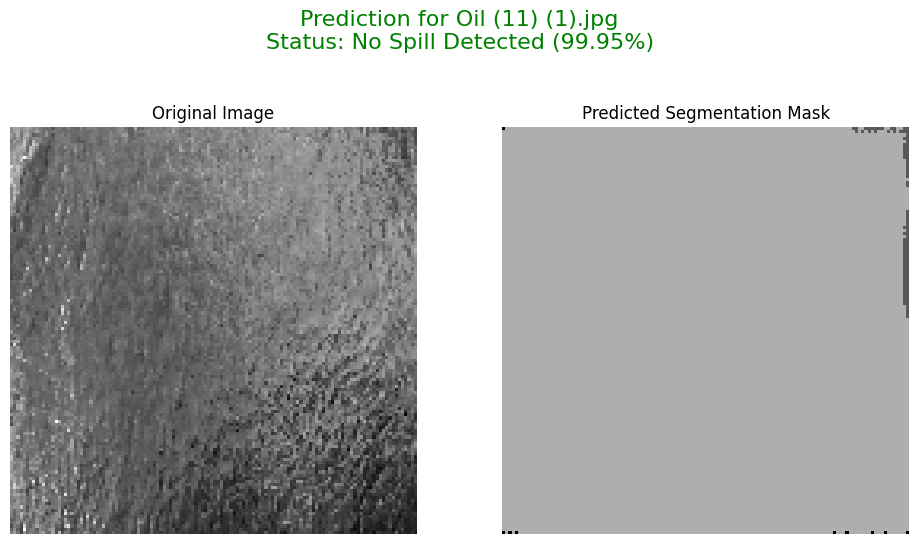


Please upload an image to test (e.g., .jpg, .png):
--> To stop, click the 'Cancel upload' button. <--


Saving Oil (916).jpg to Oil (916).jpg

Processing 'Oil (916).jpg'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Analysis complete: Oil Spill Detected (40.33%)
Displaying results:


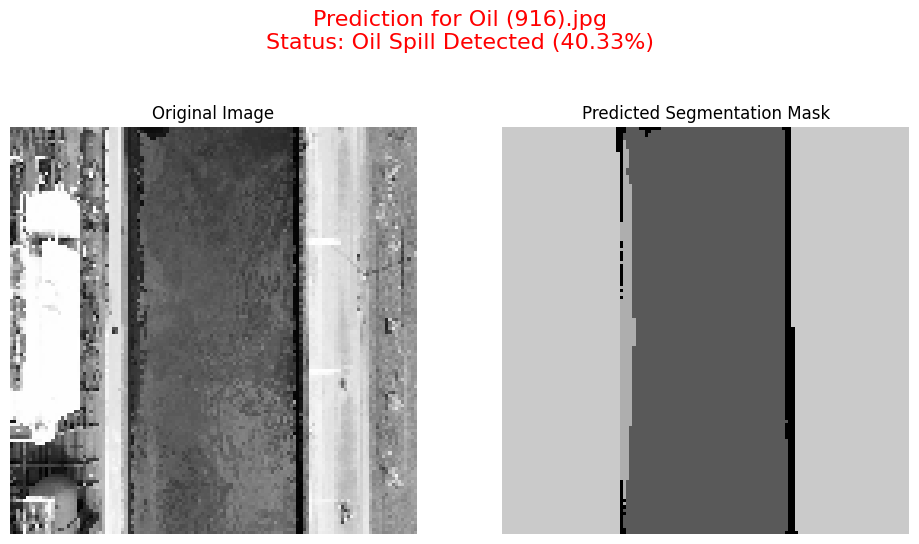


Please upload an image to test (e.g., .jpg, .png):
--> To stop, click the 'Cancel upload' button. <--


Saving Oil (14).jpg to Oil (14) (2).jpg

Processing 'Oil (14) (2).jpg'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Analysis complete: Oil Spill Detected (45.56%)
Displaying results:


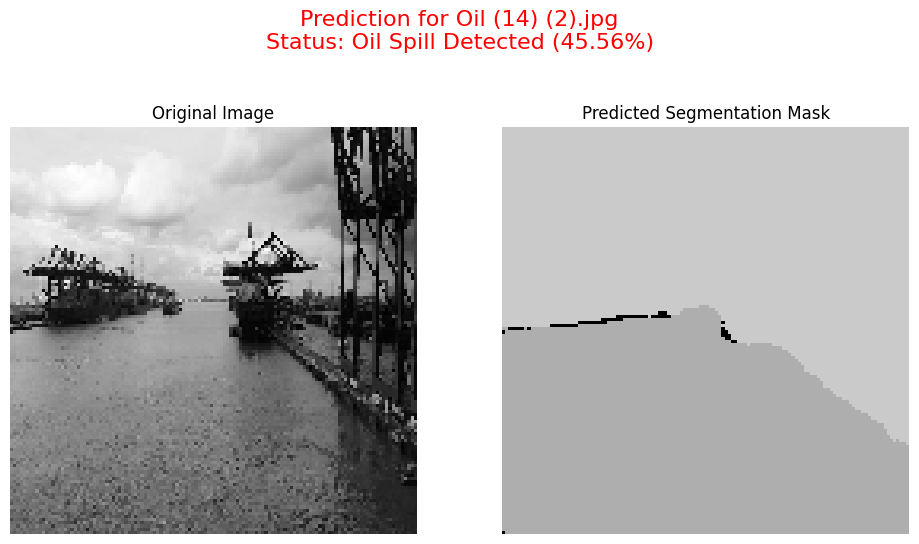


Please upload an image to test (e.g., .jpg, .png):
--> To stop, click the 'Cancel upload' button. <--


Saving Oil (79).jpg to Oil (79).jpg

Processing 'Oil (79).jpg'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Analysis complete: No Spill Detected (99.92%)
Displaying results:


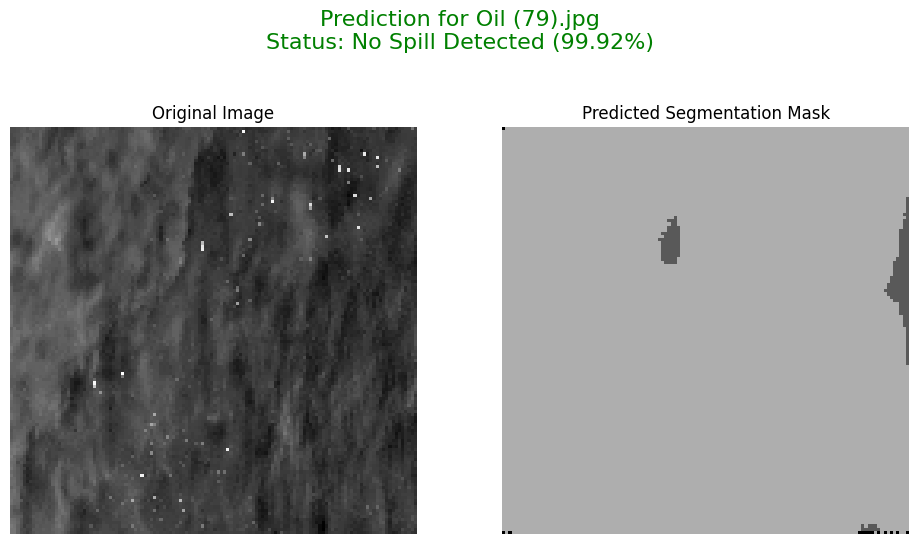


Please upload an image to test (e.g., .jpg, .png):
--> To stop, click the 'Cancel upload' button. <--


Saving Oil (1097).jpg to Oil (1097).jpg

Processing 'Oil (1097).jpg'...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Analysis complete: No Spill Detected (77.07%)
Displaying results:


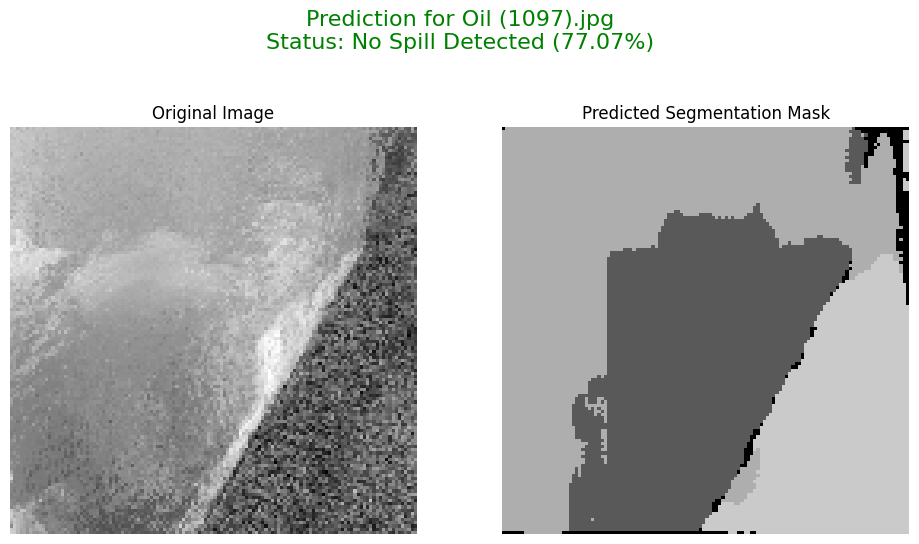


Please upload an image to test (e.g., .jpg, .png):
--> To stop, click the 'Cancel upload' button. <--



Upload cancelled. Exiting prediction loop.


In [20]:

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from google.colab import drive
from google.colab import files
import io

print("TensorFlow Version:", tf.__version__)


def unet_multiclass(input_size=(128, 128, 1), num_classes=4):
    inputs = Input(input_size)

    # Encoder Path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    p4 = MaxPooling2D((2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)

    # Decoder Path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# --- Define constants ---
IMG_SIZE = (128, 128)
CLASS_LABELS = [0, 90, 174, 202]
NUM_CLASSES = len(CLASS_LABELS)




model_path_in_drive = '/content/drive/MyDrive/oil_spill_segmentation_v1.h5'

print(f"\nLoading the trained model from: {model_path_in_drive}")
try:
    # We must provide the custom metric function to load the model successfully
    custom_objects = {'MeanIoU': tf.keras.metrics.MeanIoU(num_classes=NUM_CLASSES)}
    loaded_model = tf.keras.models.load_model(model_path_in_drive, custom_objects=custom_objects)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Please make sure the path is correct and the model file exists.")



while True:
    print("\n" + "="*50)
    print("Please upload an image to test (e.g., .jpg, .png):")
    print("--> To stop, click the 'Cancel upload' button. <--")
    uploaded_image = files.upload()

    # If the user cancels the upload, the dictionary will be empty.
    if not uploaded_image:
        print("\nUpload cancelled. Exiting prediction loop.")
        break

    image_filename = list(uploaded_image.keys())[0]
    print(f"\nProcessing '{image_filename}'...")

    # --- Preprocess the uploaded image ---
    img_bytes = io.BytesIO(uploaded_image[image_filename])
    img = load_img(img_bytes, target_size=IMG_SIZE, color_mode='grayscale')
    img_array = img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_array, axis=0)

    # --- Make a prediction ---
    pred_prob = loaded_model.predict(img_batch)[0]
    pred_indices = np.argmax(pred_prob, axis=-1)

    # --- Convert prediction to a viewable image ---
    pred_mask_colored = np.zeros_like(pred_indices, dtype=np.uint8)
    for class_index, pixel_value in enumerate(CLASS_LABELS):
        pred_mask_colored[pred_indices == class_index] = pixel_value

    # --- Analyze the prediction for spill detection ---
    # Based on observation, the class representing the oil spill is pixel value 90.
    # The other classes (e.g., 174, 202) likely represent sea, land, or look-alikes.
    SPILL_CLASSES = [90, 174]

    # Calculate the percentage of the image classified as a spill
    spill_pixel_count = np.sum(np.isin(pred_mask_colored, SPILL_CLASSES))
    total_pixels = pred_mask_colored.size
    spill_percentage = (spill_pixel_count / total_pixels) * 100

    # Set a threshold based on your observation.
    # If the percentage is low (< 50%), it implies an oil spill is present.
    # If the percentage is high (> 50%), it implies no spill (mostly sea/land).
    DETECTION_THRESHOLD_PERCENT = 50

    if spill_percentage < DETECTION_THRESHOLD_PERCENT:
        status = f"Oil Spill Detected ({spill_percentage:.2f}%)"
        status_color = 'red'
    else:
        status = f"No Spill Detected ({spill_percentage:.2f}%)"
        status_color = 'green'

    print(f"Analysis complete: {status}")

    # --- Visualize the results ---
    print("Displaying results:")
    fig = plt.figure(figsize=(10, 5.5))
    fig.suptitle(f'Prediction for {image_filename}\nStatus: {status}', fontsize=16, color=status_color, y=0.98)


    plt.subplot(1, 2, 1)
    plt.imshow(img_array.squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask_colored, cmap='gray', vmin=0, vmax=255)
    plt.title('Predicted Segmentation Mask')
    plt.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.9]) # Adjust layout to prevent title overlap
    plt.show()

